# Purpose: To build out the skeleton Pseudo Code for this project

__For now__: Moving my notes from my one one one with Elizabeth and will build out more in the next few days

1. Input .csv from experimental team to describe data
2. CSV pulls the proper images from NDP (or wherever best storage location is determined to be)
2a. There needs to be some integration with NDP to break the image into chunks with the appropriate zoom and then provide the original slice with locations of test and training images printed out.
2b. I think to do this we are going to have to register the image to some kind of atlas... or somethign to determine regions so that the code can grab pictures
3. Images need to be split
3a. Regionally
3b. Test Groups
3c. Into Small enough sizes for most efficient processing by package
3d. Magifications
4. Threshold and segment
4a. Ifthresholds (for general object identification) [July]
4b. + Skeletonization (for specific highly branched morphometric analysis) [Robin]
5. Split data into testing and training groups
6. Shape factor analysis on both models (before ML model)
7. Feed 4(1) and 4(2) separately to modified VAMPIRE package to build models
8. Store created models
9. Test models with testing data sets
10. Data output
11. Comprehensive CSV for optional additional analysis
12. Data Visualization
13. Save all data into some storage location (Google Drive?)


Other Notes: 
1. Modified VAMPIRE package: Worth forking the Wirtz lab repository now and building on by ourselves possibly – adding that fork to our repository - COMPLETE
2. Want a repository that works through Binder? Preferably so the Neonatalogy lab can do this straight through a web interface
3. Along with outputs want to output the variables used for all of the steps on days that experiments were run with an easy print out maybe for lab notebook storage? (A way to integrate the electronic lab notebook I want to get more fine tuned for our lab with a standard lab notebook - and provide some under the hood knowledge for Neonatology)

4. Add in an optimization step for what size of image is sufficient for cropping down the whole scan images 
5. Including an analysis before creating that analysis that selects the best # of shape modes and #coordinate points – maybe we could reach out the Denis Wirtz lab about this or build in our own integration



Current Goal:

1. Get a bunch of images from a slice of the ferret brain
2. Put them in a folder
3. Perform thresholding within the Jupyter Notebook
3. Integrate vampire into the Jupyter Notebook
4. Run those images and get an output within the notebook or specific folder (which should will need a results output)
5. Save all of this information to some results folder
6. See if it works in binder

Next Goals:
1. Build out ifthresholds more for immunohistochemistry stains
2. Build in NDP regional registration and automatic image breakdown
3. Integrate Google Drive
4. New visualizations based on what came from paper
5. Statistics possibly with Rthon
6. Speed up any slow processes with Cython
7. Integrate ifThresholds to pick and perform the best thresholding (or integrate a step to say whether this needs to be done or not)

*Step 1: Import necessary packages*

In [126]:
import shutil, os
import re

import numpy as np
import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import segmentation
from skimage import color

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')

from sklearn.model_selection import train_test_split

from PIL import Image

*Step 2: User Inputs*

In [127]:
#Data folder to the stain you are running morphology on (right now only works one stain at a time)
#rerun for each individual stain

#Folder breakdown: stain>animal>region>actual images
data_folder = '/Users/hhelmbre/Desktop/6-17-2020-fiberfimages/iba1'

#Image type of your images (they should all be the same type)
image_file_type = '.jpg'

#Enter the name of your stain as a string
stain1 = 'Iba1' #c1
stain2 = 'dapi' #c2

experiment_name = 'practice'

*Step X: Google Drive Integration*

1. Go to this website: https://developers.google.com/drive/api/v3/quickstart/python?authuser=1
2. Make sure the appropriate google account is open in the top right corner
3. Click "Enable the Drive API" (blue button)
4. Select 'Desktop App' from the drop down list
5. Select Create
6. Download the credentials
7. Rename them client_secrets.json


NOTE: client_secrets.json and credentials.json are files in the .gitignore for this respository. For online safety, do not change this or push either of these to Git to keep your google accounts secure.

In [ ]:
#This runs the google integration - it will open another web browser. When allowed leave the authentication page open. 
#Sometimes there is an error when this page is closed.

import pydrive
from pydrive.auth import GoogleAuth as gauth
from pydrive.drive import GoogleDrive

from pydrive.auth import GoogleAuth

#  Creates local webserver and auto handles authentication.
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

#  Create GoogleDrive instance with authenticated GoogleAuth instance
drive = GoogleDrive(gauth)

*Step X: Threshold and segment everything and then split test and train*

In [128]:
folder_list = os.listdir(data_folder)
folder_list = np.asarray(folder_list)

In [129]:
#Code for macs to get rid of an aesthetic file called '.DS_Store'
k=0
mac_annoyance= 'DS_Store'
for folders in folder_list:
    if mac_annoyance in str(folders):
        folder_list = np.delete(folder_list, (k), axis=0)
    else:
        k+=1

In [130]:
#Folder breadown should be (1) stains, (2) animals, (3) regions
#this code gets a list of the individual paths for each region folder with images
threshold_paths = []
for animals in folder_list:
    region_list = os.listdir(str(data_folder + '/' + animals))
    region_list = np.asarray(region_list)
    
    k=0
    for regions in region_list:
        if mac_annoyance in str(regions):
            region_list = np.delete(region_list, (k), axis=0)
        else:
            k+=1
    
    for regions in region_list:
        path = str(data_folder + '/' + animals + '/' + regions)
        threshold_paths.append(path)

*Step 3: Threshold and Segment Images*

Step 3a: Import and threshold images from 'data_folder' from downloaded NDP images

*need to go in and add code to create a reasonable cut off for the min_size remove small objects*

*Go in and add code that does a better job at separating overlapping cells (maybe this is just in thresholding*)

In [131]:
for paths in threshold_paths:

    #Creating a folder for the new tresholded images
    os.mkdir(str(paths + '/' + 'threshold_applied_images'))

    #initializing a pandas dataframe
    overall_region_meas = pd.DataFrame(columns = ['Filename', 'ImageID', 'ObjectID', 'X', 'Y', 'Area', 'Perimeter', 'Major Axis', 'Minor Axis', 'Circularity', 'Aspect Ratio'])

    #initializing a count
    
    image_list = os.listdir(str(paths))
    image_list = np.asarray(image_list)
    
    k=0
    for images in image_list:
        if image_file_type in str(images):
            k+=1
        else:
            image_list = np.delete(image_list, (k), axis=0)
    
    
    #Initializing an imag count
    k=1
    
    #Looping through all images in list (this task should be put to multiple CPUs in future if a large data set)
    for images in image_list:

        #initializing a pandas data frame for measurement data
        region_meas = pd.DataFrame()

        #Going through each of the images to get their binarized images and measurement info
        name = str(paths + '/' + images)
        im = io.imread(name)
        im = im[:,:,0]
        threshold = filters.threshold_otsu(im)
        binary = morphology.closing(im < threshold, morphology.square(5))
        label_image = measure.label(binary, return_num=False, connectivity=2)
        binary2 = morphology.remove_small_objects(label_image, min_size=400, connectivity=2, in_place=True)
        invert_binary2 = np.invert(binary2)

        # Saving the thresheld images to their own folder with modified names
        im_to_save = Image.fromarray(np.uint8(binary2), mode='L')
        new_name = str(paths + '/' + 'threshold_applied_images' + '/' + images)
        new_name = new_name.replace('.jpg','_threshold_ch1.jpg')
        im_to_save.save(new_name)


        #Saving the region properties as a csv
        props = measure.regionprops_table(binary2, properties= ('centroid', 'area', 'perimeter', 'major_axis_length', 'minor_axis_length'))
        props_meas = pd.DataFrame(props)
        region_meas['X'] = props_meas['centroid-0']
        region_meas['Y'] = props_meas['centroid-1']
        region_meas['Area'] = props_meas['area']
        region_meas['Perimeter'] = props_meas['perimeter']
        region_meas['Major Axis'] = props_meas['major_axis_length']
        region_meas['Minor Axis'] = props_meas['minor_axis_length']
        region_meas['Circularity'] = (region_meas['Area']*4*np.pi)/(region_meas['Perimeter']**2)
        region_meas['Aspect Ratio'] = (region_meas['Major Axis']/region_meas['Minor Axis'])
        region_meas.insert(0, 'Filename', images)
        region_meas.insert(1, 'ImageID', k)
        region_meas.insert(2, 'ObjectID', np.arange(len(region_meas)))

        overall_region_meas = overall_region_meas.append(region_meas)
        k+=1

    path = str(paths + '/' + 'threshold_applied_images/')
    overall_region_meas.to_csv(path + 'c1_registry.csv', index=False)
                           

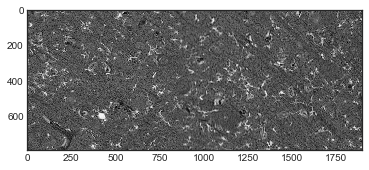

In [132]:
im = io.imread(name)
plt.imshow(im[:,:,0], cmap ='Greys')
plt.show()

In [133]:
for paths in threshold_paths:
    
    os.mkdir(str(paths + '/' + 'threshold_applied_images/' + 'dapi'))

    #initializing a pandas dataframe
    overall_region_meas = pd.DataFrame(columns = ['Filename', 'ImageID', 'ObjectID', 'X', 'Y', 'Area', 'Perimeter', 'Major Axis', 'Minor Axis', 'Circularity', 'Aspect Ratio'])
    
    
    #Initializing an imag count
    k=1
    
    image_list = os.listdir(str(paths))
    image_list = np.asarray(image_list)
    
    k=0
    for images in image_list:
        if image_file_type in str(images):
            k+=1
        else:
            image_list = np.delete(image_list, (k), axis=0)
    
    #Looping through all images in list (this task should be put to multiple CPUs in future if a large data set)
    for images in image_list:

        #initializing a pandas data frame for measurement data
        region_meas = pd.DataFrame()

        #Going through each of the images to get their binarized images and measurement info
        name = str(paths + '/' + images)
        im = io.imread(name)
        im = im[:,:,2]
        threshold = filters.threshold_otsu(im)
        binary = morphology.closing(im < threshold, morphology.square(5))
        label_image = measure.label(binary, return_num=False, connectivity=2)
        binary2 = morphology.remove_small_objects(label_image, min_size=400, connectivity=2, in_place=True)
        invert_binary2 = np.invert(binary2)

        # Saving the thresheld images to their own folder with modified names
        im_to_save = Image.fromarray(np.uint8(binary2), mode='L')
        new_name = str(paths + '/' + 'threshold_applied_images/' + 'dapi/' + images)
        new_name = new_name.replace('.jpg','_threshold_ch2.jpg')
        im_to_save.save(new_name)


        #Saving the region properties as a csv
        props = measure.regionprops_table(binary2, properties= ('centroid', 'area', 'perimeter', 'major_axis_length', 'minor_axis_length'))
        props_meas = pd.DataFrame(props)
        region_meas['X'] = props_meas['centroid-0']
        region_meas['Y'] = props_meas['centroid-1']
        region_meas['Area'] = props_meas['area']
        region_meas['Perimeter'] = props_meas['perimeter']
        region_meas['Major Axis'] = props_meas['major_axis_length']
        region_meas['Minor Axis'] = props_meas['minor_axis_length']
        region_meas['Circularity'] = (region_meas['Area']*4*np.pi)/(region_meas['Perimeter']**2)
        region_meas['Aspect Ratio'] = (region_meas['Major Axis']/region_meas['Minor Axis'])
        region_meas.insert(0, 'Filename', images)
        region_meas.insert(1, 'ImageID', k)
        region_meas.insert(2, 'ObjectID', np.arange(len(region_meas)))

        overall_region_meas = overall_region_meas.append(region_meas)
        k+=1

    path = str(paths + '/' + 'threshold_applied_images/')
    overall_region_meas.to_csv(path + 'c2_registry.csv', index=False)

*Step X: Test and Train Split before Thresholding*

In [134]:
#Go through all the threshold paths + the threshold folder and assign 8 of them for training and 2 of them for testing

In [135]:
test_paths = []
for animals in folder_list:
    region_list = os.listdir(str(data_folder + '/' + animals))
    region_list = np.asarray(region_list)
    
    k=0
    for regions in region_list:
        if mac_annoyance in str(regions):
            region_list = np.delete(region_list, (k), axis=0)
        else:
            k+=1
    
    for regions in region_list:
        path = str(data_folder + '/' + animals + '/' + regions + '/' + 'threshold_applied_images/')
        test_paths.append(path)


In [136]:
os.mkdir(str(data_folder + '/' + 'train'))

name_count = 0

for paths in test_paths:
    
    image_list = os.listdir(str(paths))
    image_list = np.asarray(image_list)
    
    k=0
    for images in image_list:
        if image_file_type in str(images):
            k+=1
        else:
            image_list = np.delete(image_list, (k), axis=0)

    X_train, X_test= train_test_split(image_list, test_size=0.20, random_state=1)

    for names in image_list:
        test_name_count = 1
        
        if names in X_train[:]:
            shutil.move(str(paths + '/' + names), str(data_folder + '/' + 'train'))
            
            
            train_name = str(data_folder + '/' + 'train/' + names)
            string_count = str(name_count)
            replace_name = str('xy' + string_count + stain + 'ch1' + '.jpg')
            os.rename(str(data_folder + '/' + 'train/' + names), str(data_folder + '/' + 'train/' + replace_name))
            
            
            dapi_name = names.replace('_ch1', '_ch2')
            shutil.move(str(paths + '/dapi/' + dapi_name), str(data_folder + '/' + 'train'))
            replace_dapi_name = str('xy' + string_count + stain + 'ch2' + '.jpg')
            os.rename(str(data_folder + '/' + 'train/' + dapi_name), str(data_folder + '/' + 'train/' + replace_dapi_name))
            
            
            name_count +=1
            
            
        else:
            #renaming the testing groups
            string_test_name_count = str(test_name_count)
            os.rename(str(paths + '/' + names), str(paths + '/' + 'xy' + string_test_name_count + 'ch1' + '.jpg'))
            
            dapi_name = names.replace('_ch1', '_ch2')
            shutil.move(str(paths + '/dapi/' + dapi_name), str(paths))
            os.rename(str(paths + '/' + dapi_name), str(paths + '/' + 'xy' + string_test_name_count + 'ch2' + '.jpg'))
            
            test_name_count += 1
            
    os.rmdir(str(paths + 'dapi'))

# Step 3: Vampire Analysis

*The following will pull up the GUI as a popup - I want to be able to input values into the GUI straight from here not have to point and click*

#We are going to work with what we have an have a print out here of what to input in the VAMPIRE GUI - it is still faster than it used to be. 

(1) Build and then apply model with the vampire GUI (will work on making it not GUI later)

*Step X: Create the CSVs for Building and applying the model*

In [137]:
#create a model repository to store the output information
#create a csv for building the model
#create a csv for applying the model

In [138]:
#creates the directory in your data folder to put all information related to the model
os.mkdir(str(data_folder + '/' + 'model'))

In [139]:
#creates the csv for building a model
data = [['all_training', '1', str(data_folder + '/' + 'train'), stain, 'ch1', 'ch2']]
build_model_csv = pd.DataFrame(data, columns = ['condition', 'set number', 'set location', 'note', 'ch1', 'ch2']) 

#saves csv to newly created model directory
build_model_csv.to_csv(data_folder + '/' + 'model/' + 'images_to_build_model.csv', index=False)

In [140]:
#creates the csv for applying a model
apply_model_csv = pd.DataFrame(columns = ['condition', 'set number', 'set location', 'note', 'ch1', 'ch2'])

set_number = 1
for folders in test_paths:
    str_set_number = str(set_number)
    pattern = str(data_folder + '/' + '(.*?)' + '/threshold_applied_images/')
    substring = re.search(pattern, folders).group(1)

    df2 = pd.DataFrame({'condition': [substring], 'set number': [str_set_number], 'set location': [folders], 'note': [stain], 'ch1': ['ch1'], 'ch2': ['ch2']})
    apply_model_csv = apply_model_csv.append(df2)
    
    set_number += 1
    
apply_model_csv.to_csv(data_folder + '/' + 'model/' + 'images_to_apply_model.csv', index=False)

Step X: Print the inputs that should be added to VAMPIRE

In [141]:
print('Build Model CSV Path:', str(data_folder + '/' + 'model/' + 'images_to_build_model.csv'))
print('Apply Model CSV Path:', str(data_folder + '/' + 'model/' + 'images_to_apply_model.csv'))
print('Number of Shape Models (Recommended):', '5')
print('Number of Shape Coordinates (Recommended):', '50')
print('Model Name:', experiment_name)
print('Model to Apply:', str(data_folder + '/' + 'model/' + experiment_name))

Build Model CSV Path: /Users/hhelmbre/Desktop/6-17-2020-fiberfimages/iba1/model/images_to_build_model.csv
Apply Model CSV Path: /Users/hhelmbre/Desktop/6-17-2020-fiberfimages/iba1/model/images_to_apply_model.csv
Number of Shape Models (Recommended): 5
Number of Shape Coordinates (Recommended): 50
Model Name: practice
Model to Apply: /Users/hhelmbre/Desktop/6-17-2020-fiberfimages/iba1/model/practice


*Step X: Open the VAMPIRE GUI, build, and then apply the model*

In [100]:
import vampireanalysis
from vampireanalysis import vampire

In [103]:
vampire()

## getboundary.py
Check Label Status: Good
Check Label Status: Good


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/hhelmbre/opt/anaconda3/envs/vampirenv/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/hhelmbre/opt/anaconda3/envs/vampirenv/lib/python3.7/site-packages/vampireanalysis/vampire.py", line 133, in <lambda>
    b5 = Button(rows[9], text='apply model', width=12, command=(lambda e=ents: Model(e, False, progress_bar)))
  File "/Users/hhelmbre/opt/anaconda3/envs/vampirenv/lib/python3.7/site-packages/vampireanalysis/vampire.py", line 91, in Model
    getboundary(csv, progress_bar, entries)  # create registry csv and boundary stack
  File "/Users/hhelmbre/opt/anaconda3/envs/vampirenv/lib/python3.7/site-packages/vampireanalysis/getboundary.py", line 112, in getboundary
    df = pd.DataFrame(boundarymaster)
  File "/Users/hhelmbre/opt/anaconda3/envs/vampirenv/lib/python3.7/site-packages/pandas/core/frame.py", line 464, in __init__
    mgr = init_ndarray(data, index,

*Step 8: New visualization of VAMPIRE data*

- This should probably be built into VAMPIRE and not just into this notebook - think about this for the future

There still needs to be visualization steps here because what is output by vampire just is not great